## A use case of palette based image colorization with palette-image model
- The palette embedding is pre-created for evaluation experiments with test dataset

In [1]:
from share import *
import config

import cv2
import einops
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler
from dataset import MyPaletteDataset

logging improved.


In [2]:
model = create_model('./models/cldm_v15.yaml').cpu()
model_path = 'checkpoints/palette-image-model-plt-injected-epoch=29.ckpt'
model.load_state_dict(load_state_dict(model_path, location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [checkpoints/palette-image-model-plt-injected-epoch=29.ckpt]


In [3]:
def process(input_image, grey_image, palette_emb, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = grey_image
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples, [palette_emb.cpu().numpy()] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples, [] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return results

In [4]:
# draw palette without color rate
def draw_palette(colors):
    palette = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for c in range(len(colors)):
        endX = startX + (1 / len(colors) * 300)
        cv2.rectangle(palette, (int(startX), 0), (int(endX), 50), colors[c], -1)
        startX = endX
    return palette

Global seed set to 1
/home/jovyan/PaletteControl/ldm/modules/encoders/modules.py:181: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/torch/csrc/utils/tensor_new.cpp:201.)
  p_input = torch.tensor(palette)


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Grayscale image:


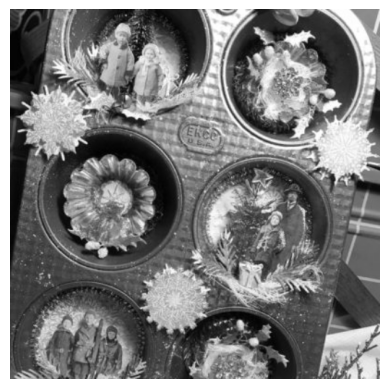

Reference image:


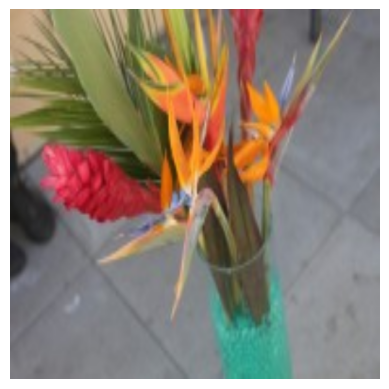

Reference palette from image:


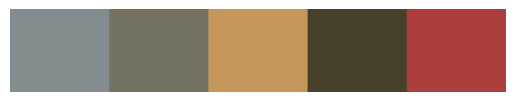

Colorized image:


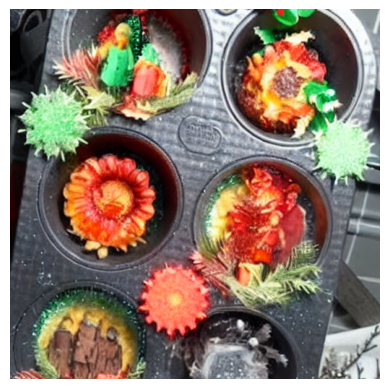

In [5]:
dataset = MyPaletteDataset('test')

idx = 8
idx_ref = 0 # 0-7 is available in this demo

item = dataset[idx]
item_next = dataset[idx_ref]
input_image = item['jpg']
grey_image = item['hint']
prompt = item['txt']
reference_image = item_next['jpg']
palette = item_next['plt_v']
palette_emb = item_next['plt']
result_folder = 'results'

num_samples = 1
image_resolution = 512
strength = 1.0
guess_mode = False
low_threshold = 100
high_threshold = 200
ddim_steps = 50 # 20 similar with 50 results
scale = 9.0
seed = 1 # default 1
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

results = process(input_image, grey_image, palette_emb, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold)

print("Grayscale image:")
plt.imshow(grey_image)
plt.axis('off')
plt.show()

print("Reference image:")
plt.imshow(reference_image)
plt.axis('off')
plt.show()

print("Reference palette from image:")
input_plt = draw_palette(palette)
plt.imshow(input_plt)
plt.axis('off')
plt.show()

for i, arr in enumerate(results):
    # 转换数组到图像
    image = np.array(arr, dtype=np.uint8)

    # 保存图像为PNG
    print("Colorized image:")
    plt.imshow(image)
    plt.axis('off')
    plt.show()
